In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install rasterio matplotlib numpy
import rasterio
import numpy as np
import matplotlib.pyplot as plt

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 80.7 MB/s eta 0:00:00


In [ ]:
date1_red = '/content/drive/MyDrive/GEOL0069/final assignment/T27WXN_20250412T125311_B04_10m.jp2'  # April 12 (Red)
date1_nir = '/content/drive/MyDrive/GEOL0069/final assignment/T27WXN_20250412T125311_B08_10m.jp2'  # April 12 (NIR)
date2_red = '/content/drive/MyDrive/GEOL0069/final assignment/T27WXN_20250520T125321_B04_10m.jp2'  # May 20 (Red)
date2_nir = '/content/drive/MyDrive/GEOL0069/final assignment/T27WXN_20250520T125321_B08_10m.jp2'  # May 20 (NIR)

In [ ]:

#def calculate_ndvi(red_band, nir_band):
    #ndvi = (nir_band - red_band) / (nir_band + red_band + 1e-10)  # Avoid division by zero
    #return ndvi

# NDVI for April and May
#ndvi_april = calculate_ndvi(red_april, nir_april)
#ndvi_may = calculate_ndvi(red_may, nir_may)

In [ ]:
import rasterio
import numpy as np

# Load just a small window for fast testing
def load_band_crop(file_path):
    with rasterio.open(file_path) as src:
        return src.read(1, window=((0, 1000), (0, 1000))).astype('float32')

red_april = load_band_crop(date1_red)
nir_april = load_band_crop(date1_nir)
red_may = load_band_crop(date2_red)
nir_may = load_band_crop(date2_nir)

# NDVI
ndvi_april = (nir_april - red_april) / (nir_april + red_april + 1e-10)
ndvi_may = (nir_may - red_may) / (nir_may + red_may + 1e-10)

print("NDVI min4:", np.min(ndvi_april))
print("NDVI max4:", np.max(ndvi_april))
print("NDVI min5:", np.min(ndvi_may))
print("NDVI max5:", np.max(ndvi_may))

NDVI min4: -0.23262112
NDVI max4: 0.69058526
NDVI min5: -0.34196892
NDVI max5: 0.7113402


In [ ]:
def calculate_ndvi(red, nir):
    """Calculate Normalized Difference Vegetation Index with safety checks.

    Args:
        red (ndarray): Red band reflectance (0-1 scale)
        nir (ndarray): Near-infrared band reflectance (0-1 scale)

    Returns:
        ndarray: NDVI values in range [-1, 1] with NaNs for invalid pixels
    """
    # Mask invalid values (negative reflectances or divide-by-zero)
    mask = (nir + red) <= 0
    ndvi = np.divide(
        nir - red,
        nir + red + 1e-10,  # Small epsilon to avoid division by zero
        out=np.full_like(red, np.nan),  # Return NaN where invalid
        where=~mask
    )
    return np.clip(ndvi, -1, 1)  # Force values to theoretical range

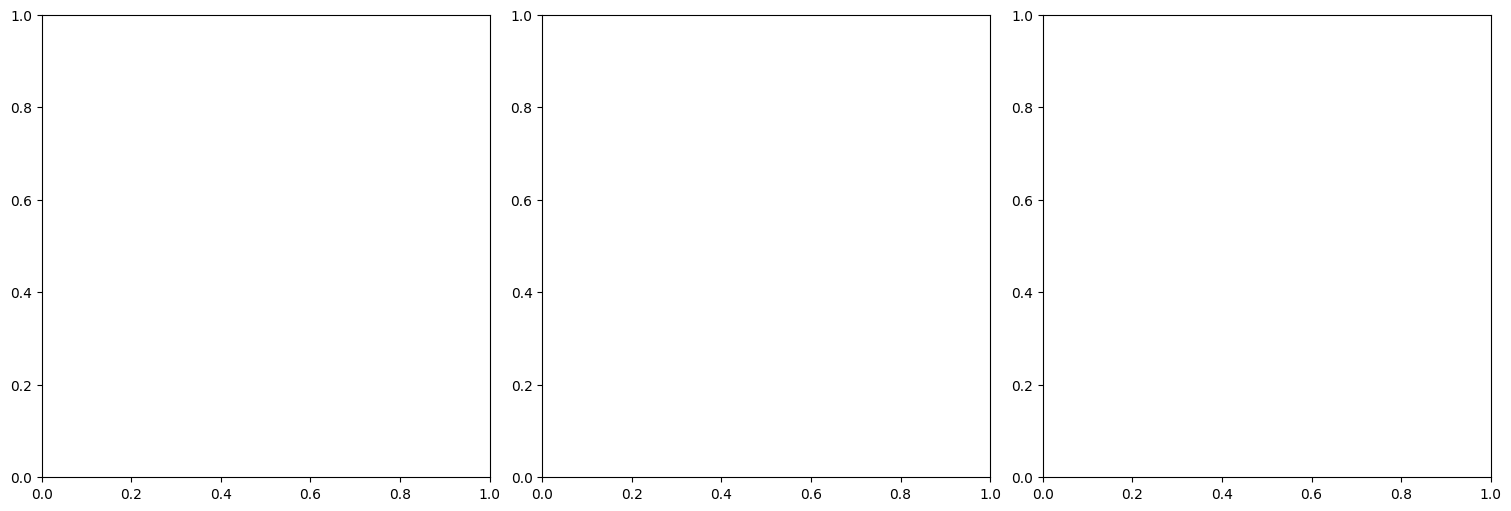

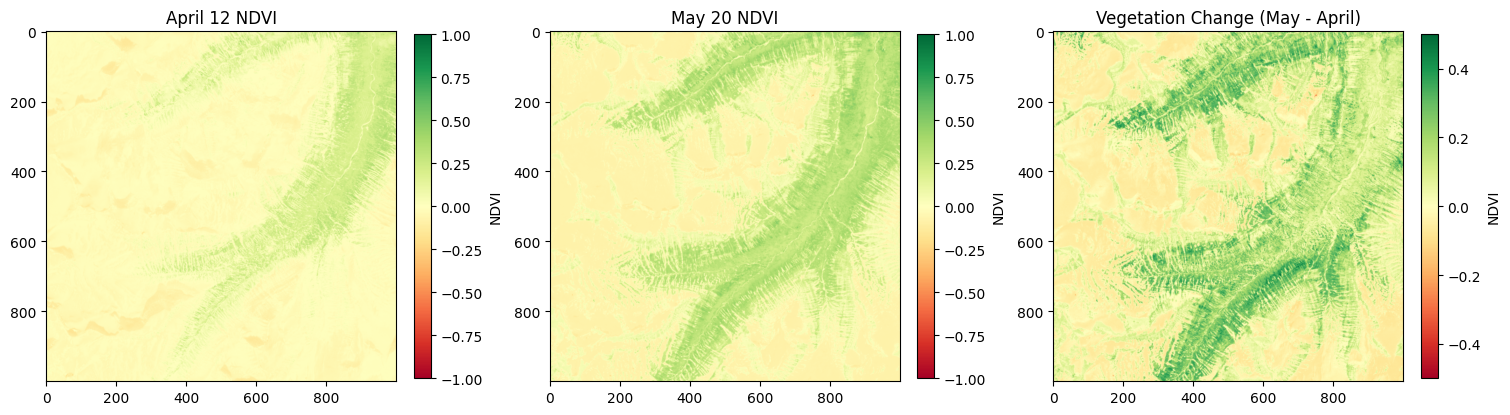

In [ ]:
def plot_ndvi_subset(data, title, cmap='RdYlGn', vmin=-1, vmax=1, ax=None):

    if ax is None:
        ax = plt.gca()

    # Downsample by taking every 4th pixel (adjust based on your RAM)
    subset = data[::1, ::1]

    # Plot with interpolation for smoother appearance
    img = ax.imshow(subset, cmap=cmap, vmin=vmin, vmax=vmax,
                   interpolation='bilinear')
    plt.colorbar(img, ax=ax, label='NDVI' if 'ΔNDVI' not in title else 'ΔNDVI', shrink=0.7)
    ax.set_title(title)
    return img

# Create figure with constrained layout
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5), constrained_layout=True)

ndvi_april = calculate_ndvi(red_april, nir_april)
ndvi_may = calculate_ndvi(red_may, nir_may)

# 3. Plot
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5), constrained_layout=True)
plot_ndvi_subset(ndvi_april, 'April 12 NDVI', ax=ax1)
plot_ndvi_subset(ndvi_may, 'May 20 NDVI', ax=ax2)
plot_ndvi_subset(ndvi_may - ndvi_april, 'Vegetation Change (May - April)', cmap='RdYlGn', vmin=-0.5, vmax=0.5, ax=ax3)
plt.show()

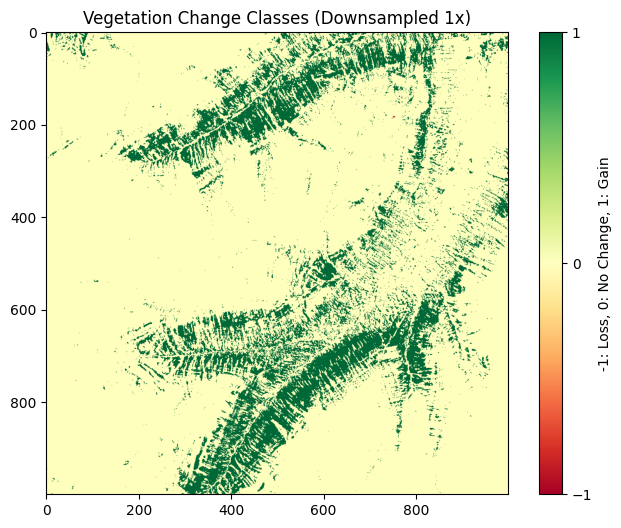

In [ ]:
def classify_changes(delta_ndvi, improvement_thresh=0.2, degradation_thresh=-0.2, downsample_factor=1):
    """Memory-friendly change classification with downsampling"""
    # Downsample the delta_ndvi array first
    delta_small = delta_ndvi[::downsample_factor, ::downsample_factor]

    # Classify changes on the downsampled array
    classified = np.empty_like(delta_small, dtype=np.int8)
    classified.fill(-99)  # Initialize with invalid value

    # Process in chunks (memory-efficient)
    chunk_size = 1000  # Adjust based on your RAM
    for i in range(0, delta_small.shape[0], chunk_size):
        for j in range(0, delta_small.shape[1], chunk_size):
            chunk = delta_small[i:i+chunk_size, j:j+chunk_size]
            classified[i:i+chunk_size, j:j+chunk_size] = np.where(
                chunk > improvement_thresh, 1,
                np.where(chunk < degradation_thresh, -1, 0))

    return classified

# Usage:
delta_ndvi = ndvi_may - ndvi_april  # Your existing delta calculation
classified = classify_changes(delta_ndvi, downsample_factor=1)  # Reduce resolution 4x

# Plot (now much smaller array)
plt.figure(figsize=(8, 6))
plt.imshow(classified, cmap='RdYlGn', vmin=-1, vmax=1)
plt.colorbar(ticks=[-1, 0, 1], label='-1: Loss, 0: No Change, 1: Gain')
plt.title('Vegetation Change Classes (Downsampled 1x)')
plt.show()



Chunked Processing:

Breaks the downsampled image into 1000×1000 pixel chunks

Processes each chunk separately to avoid loading the entire array into memory

Why? Prevents RAM overload while maintaining the same classification logic

Classification Logic:

1 (Green): Pixels where ΔNDVI > 0.2 (significant vegetation growth)

-1 (Red): Pixels where ΔNDVI < -0.2 (significant vegetation loss)

0 (Yellow): Pixels with minimal change (-0.2 ≤ ΔNDVI ≤ 0.2)
Red	-1	Areas with vegetation loss (e.g., deforestation, drought)
Yellow	0	Stable areas with minimal change
Green	1	Areas with vegetation gain (e.g., crop growth, reforestation)


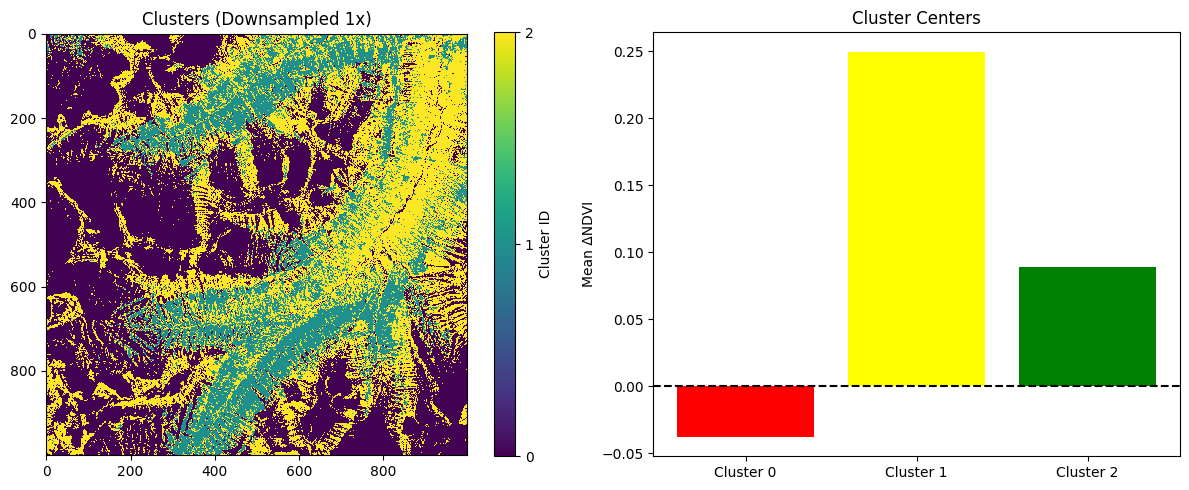

In [ ]:


from sklearn.cluster import KMeans

from skimage.transform import downscale_local_mean

def fast_ndvi_clustering(delta_ndvi, n_clusters=3, downsample_factor=1):
    """Lightning-fast approximate clustering"""
    # 1. Downsample the array first (key speed boost)
    delta_small = downscale_local_mean(delta_ndvi,
                                     factors=(downsample_factor, downsample_factor))

    # 2. Remove NaNs and reshape for clustering
    valid_mask = ~np.isnan(delta_small)
    X = delta_small[valid_mask].reshape(-1, 1)

    # 3. Cluster on the small array
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    labels = kmeans.fit_predict(X)

    # 4. Create full-size output (approximate)
    cluster_map = np.full_like(delta_small, np.nan)
    cluster_map[valid_mask] = labels

    return cluster_map, kmeans, delta_small, downsample_factor  # Now returns downsample_factor

# --------------------------------------------------
# Usage (typically runs in 1-5 minutes):
# --------------------------------------------------
# 1. Run clustering (with explicit downsample factor)
downsample_factor = 1  # Define it here for global access
cluster_map, model, delta_small, _ = fast_ndvi_clustering(delta_ndvi, downsample_factor=downsample_factor)

# 2. Visualize clusters
plt.figure(figsize=(12, 5))

# Cluster map
plt.subplot(1, 2, 1)
plt.imshow(cluster_map, cmap='viridis', interpolation='nearest')
plt.colorbar(ticks=range(3), label='Cluster ID')
plt.title(f'Clusters (Downsampled {downsample_factor}x)')  # Now works!

# Cluster centers
plt.subplot(1, 2, 2)
centers = model.cluster_centers_.flatten()
plt.bar(range(len(centers)), centers, color=['red', 'yellow', 'green'])
plt.axhline(0, color='black', linestyle='--')
plt.xticks(range(len(centers)), [f'Cluster {i}' for i in range(len(centers))])
plt.ylabel('Mean ΔNDVI')
plt.title('Cluster Centers')

plt.tight_layout()
plt.show()


Purpose: Identify vegetation change magnitude between two dates
Clusters: 3 groups (yellow part same, purple part gain, blue part loss)
Best for: Quick change detection                            
 Input: 1 feature (change value)
Output: Direct change classes.Pros: Simple, memory-efficient. Cons: Loses original NDVI context

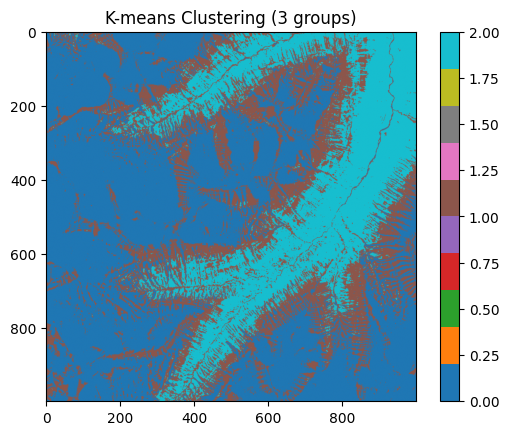

In [ ]:
from sklearn.cluster import KMeans

# Stack features: April NDVI and May NDVI
X = np.dstack((ndvi_april, ndvi_may)).reshape(-1, 2)

# Remove invalid pixels (e.g., where NDVI is nan)
valid_mask = ~np.isnan(X).any(axis=1)
X_valid = X[valid_mask]

# Fit K-means
kmeans = KMeans(n_clusters=3, random_state=42)
labels = kmeans.fit_predict(X_valid)

# Create label image
label_image = np.full(ndvi_april.size, np.nan)
label_image[valid_mask] = labels
label_image = label_image.reshape(ndvi_april.shape)
plt.imshow(label_image, cmap='tab10')
plt.colorbar()
plt.title('K-means Clustering (3 groups)')
plt.show()

April,May               
Low,Low → 0
High,Low → 1
Med,High → 2

Purpose: Group pixels with similar pre/post vegetation states
Clusters: 3 groups (patterns in April→May NDVI)
Best for: Land cover trajectory analysis

Input: 2 features (April + May values)
Output: State transition groups
Pros: Reveals trajectory patterns
Cons: Harder to interpret, needs more RAM

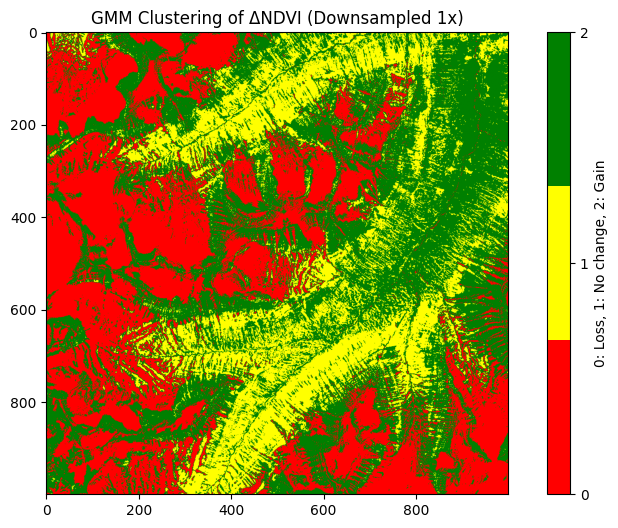

Component Means (ΔNDVI): [-0.05  0.24  0.07]


In [ ]:
import numpy as np
from sklearn.mixture import GaussianMixture
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from skimage.transform import downscale_local_mean

# 1. Downsample ΔNDVI first (key speed boost)
delta_ndvi_small = downscale_local_mean(ndvi_may - ndvi_april, factors=(1, 1))

# 2. Prepare data
valid_mask = ~np.isnan(delta_ndvi_small)
X = delta_ndvi_small[valid_mask].reshape(-1, 1)

# 3. Fit GMM on a random subset (further speedup)
sample_size = min(100000, len(X))  # Use 100k pixels or all if <100k
X_sample = X[np.random.choice(len(X), sample_size, replace=False)]

gmm = GaussianMixture(n_components=3, random_state=42)
gmm.fit(X_sample)

# 4. Predict for visualization
labels = gmm.predict(X)

# 5. Reconstruct map
gmm_map = np.full_like(delta_ndvi_small, np.nan)
gmm_map[valid_mask] = labels

# Plot (downsampled)
plt.figure(figsize=(10,6))
plt.imshow(gmm_map, cmap=ListedColormap(['red', 'yellow', 'green']))
plt.colorbar(ticks=[0,1,2], label='0: Loss, 1: No change, 2: Gain')
plt.title('GMM Clustering of ΔNDVI (Downsampled 1x)')
plt.show()

print("Component Means (ΔNDVI):", gmm.means_.flatten().round(2))

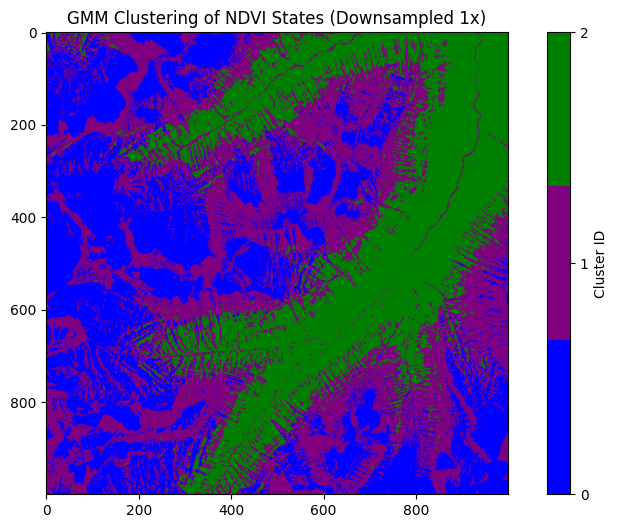

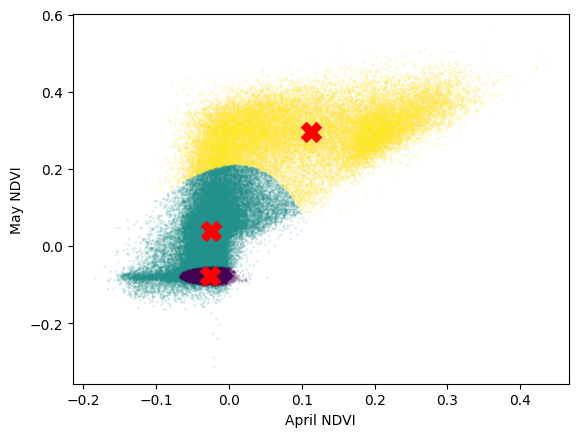

In [ ]:
# 1. Downsample both NDVI arrays first
ndvi_april_small = downscale_local_mean(ndvi_april, factors=(1, 1))
ndvi_may_small = downscale_local_mean(ndvi_may, factors=(1, 1))

# 2. Prepare 2D features
X = np.column_stack((ndvi_april_small.ravel(), ndvi_may_small.ravel()))
valid_mask = ~np.isnan(X).any(axis=1)

# 3. Fit on subset
X_valid = X[valid_mask]
sample_size = min(100000, len(X_valid))
gmm = GaussianMixture(n_components=3, random_state=42)
gmm.fit(X_valid[np.random.choice(len(X_valid), sample_size, replace=False)])

# 4. Predict and plot
labels = gmm.predict(X_valid)
gmm_map = np.full(ndvi_april_small.shape, np.nan)
gmm_map.ravel()[valid_mask] = labels

plt.figure(figsize=(10,6))
plt.imshow(gmm_map, cmap=ListedColormap(['blue', 'purple', 'green']))
plt.colorbar(ticks=[0,1,2], label='Cluster ID')
plt.title('GMM Clustering of NDVI States (Downsampled 1x)')

# Component visualization
plt.figure()
plt.scatter(X_valid[::10,0], X_valid[::10,1], c=labels[::10], alpha=0.1, s=1)
plt.scatter(gmm.means_[:,0], gmm.means_[:,1], c='red', s=200, marker='X')
plt.xlabel('April NDVI'); plt.ylabel('May NDVI')
plt.show()

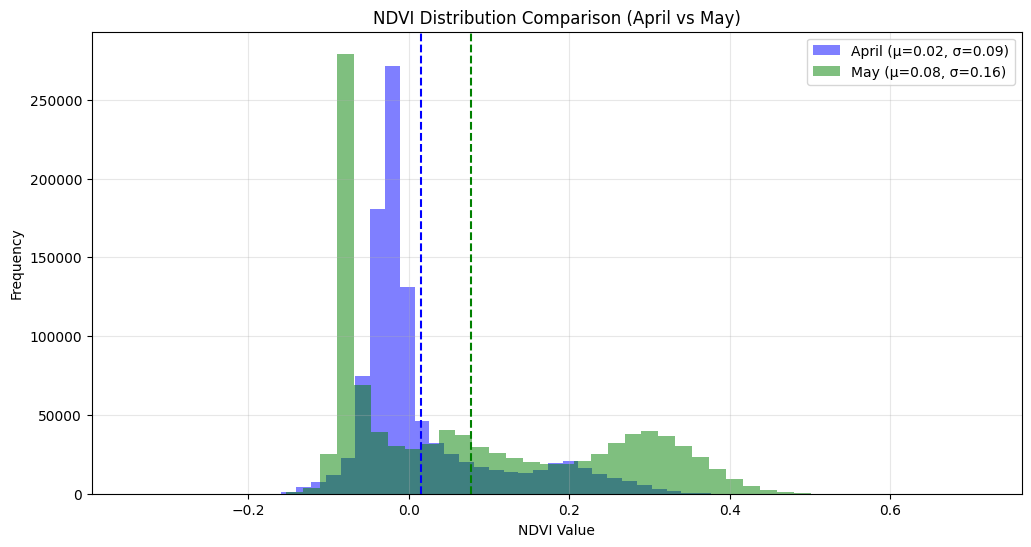

In [ ]:
april_data = ndvi_april[~np.isnan(ndvi_april)].flatten()
may_data = ndvi_may[~np.isnan(ndvi_may)].flatten()

# Calculate means and standard deviations
mean_april = np.mean(april_data)
std_april = np.std(april_data)

mean_may = np.mean(may_data)
std_may = np.std(may_data)

# Create a more detailed statistical plot similar to the first document's approach
plt.figure(figsize=(12, 6))

# Plot April distribution
april_data = ndvi_april[~np.isnan(ndvi_april)].flatten()
plt.hist(april_data, bins=50, alpha=0.5, color='blue',
         label=f'April (μ={mean_april:.2f}, σ={std_april:.2f})')

# Plot May distribution
may_data = ndvi_may[~np.isnan(ndvi_may)].flatten()
plt.hist(may_data, bins=50, alpha=0.5, color='green',
         label=f'May (μ={mean_may:.2f}, σ={std_may:.2f})')

plt.axvline(mean_april, color='blue', linestyle='--')
plt.axvline(mean_may, color='green', linestyle='--')

plt.xlabel('NDVI Value')
plt.ylabel('Frequency')
plt.title('NDVI Distribution Comparison (April vs May)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

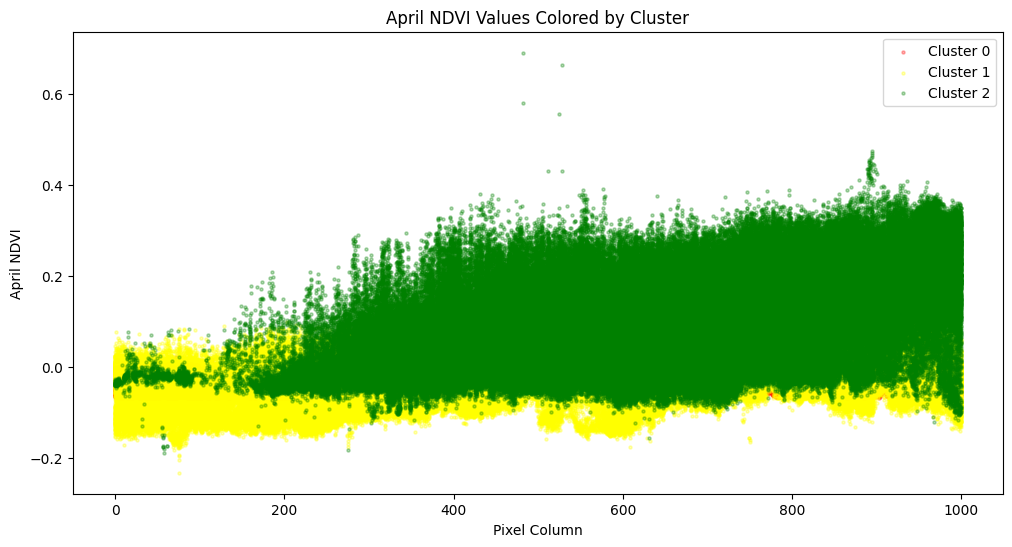

In [ ]:
# Plot all April NDVI values colored by cluster
plt.figure(figsize=(12, 6))
for cluster_id in range(3):
    cluster_mask = (gmm_map == cluster_id)
    plt.scatter(np.where(cluster_mask)[1], ndvi_april_small[cluster_mask],
                alpha=0.3, s=5,
                label=f'Cluster {cluster_id}',
                c=['red', 'yellow', 'green'][cluster_id])
plt.xlabel('Pixel Column')
plt.ylabel('April NDVI')
plt.title('April NDVI Values Colored by Cluster')
plt.legend()
plt.show()

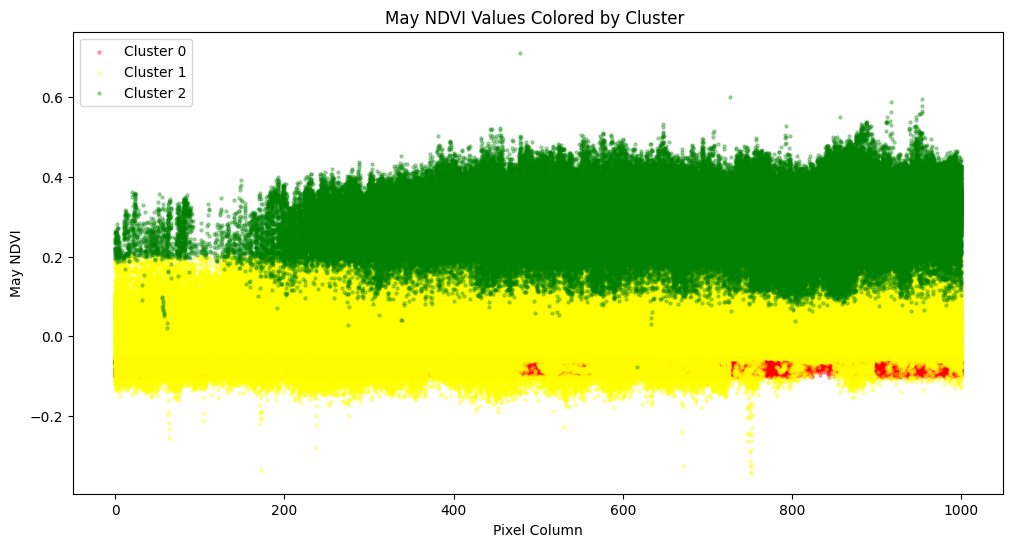

In [ ]:
# Plot all NDVI values colored by cluster (similar to waveform plots)
plt.figure(figsize=(12, 6))
for cluster_id in range(3):
    cluster_mask = (gmm_map == cluster_id)
    plt.scatter(np.where(cluster_mask)[1], ndvi_may_small[cluster_mask],
                alpha=0.3, s=5,
                label=f'Cluster {cluster_id}',
                c=['red', 'yellow', 'green'][cluster_id])
plt.xlabel('Pixel Column')
plt.ylabel('May NDVI')
plt.title('May NDVI Values Colored by Cluster ')
plt.legend()
plt.show()

Shapes - ndvi_april_small: (1000, 1000), ndvi_may_small: (1000, 1000), gmm_map: (1000, 1000)


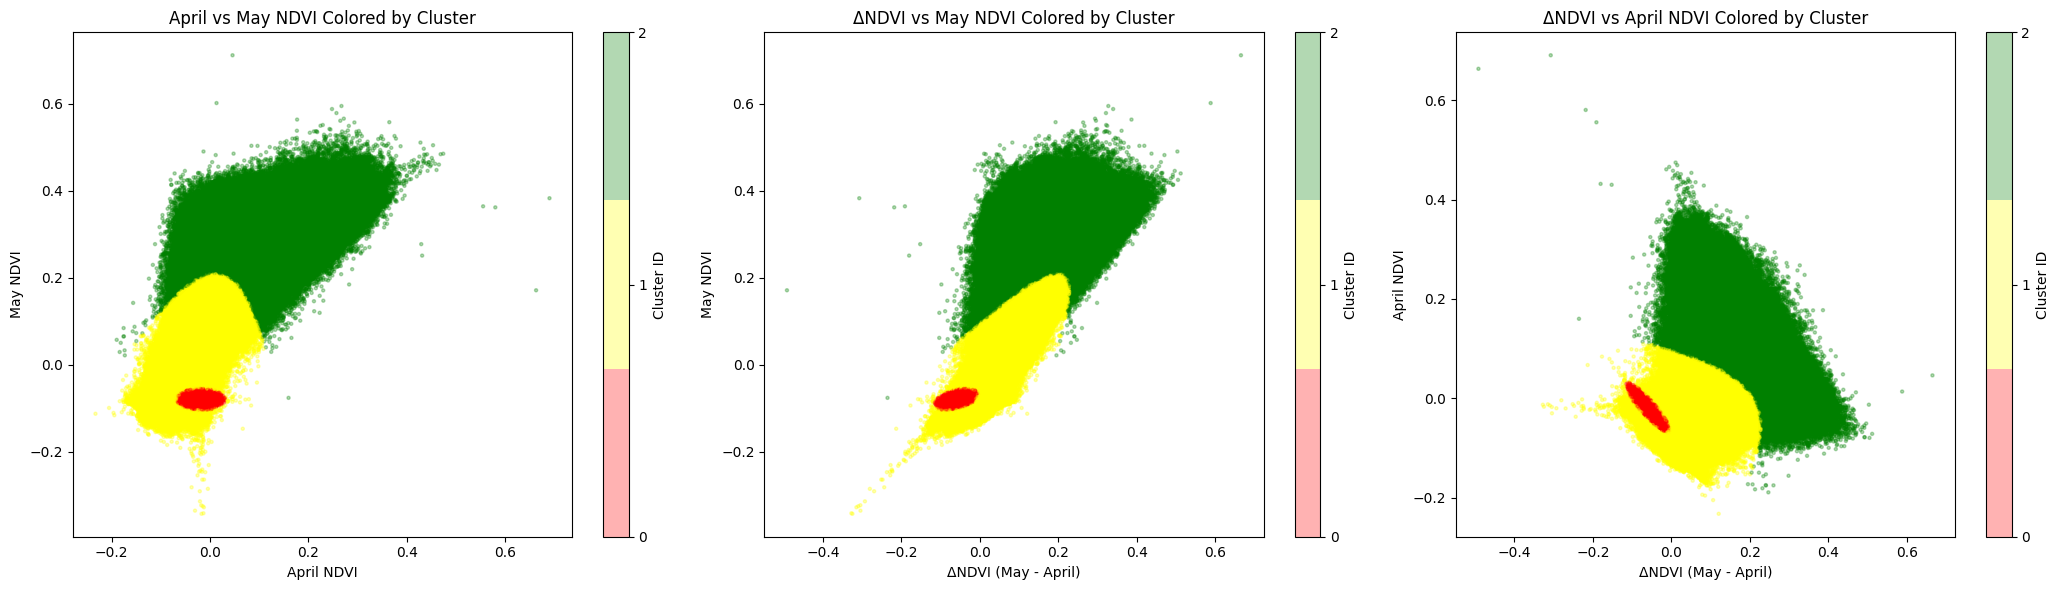

In [ ]:
# First ensure all arrays have compatible dimensions
print(f"Shapes - ndvi_april_small: {ndvi_april_small.shape}, ndvi_may_small: {ndvi_may_small.shape}, gmm_map: {gmm_map.shape}")

# Create valid mask from the downsampled arrays (not original)
valid_mask_small = ~np.isnan(ndvi_april_small) & ~np.isnan(ndvi_may_small)

# Compute delta NDVI
delta_ndvi_small = ndvi_may_small - ndvi_april_small

# Create feature pair plots (now 3 subplots)
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(21, 6))

# 1. April NDVI vs May NDVI
sc1 = ax1.scatter(ndvi_april_small[valid_mask_small],
                  ndvi_may_small[valid_mask_small],
                  c=gmm_map[valid_mask_small],
                  cmap=ListedColormap(['red', 'yellow', 'green']),
                  alpha=0.3, s=5)
ax1.set_xlabel('April NDVI')
ax1.set_ylabel('May NDVI')
ax1.set_title('April vs May NDVI Colored by Cluster')
plt.colorbar(sc1, ax=ax1, ticks=[0,1,2], label='Cluster ID')

# 2. ΔNDVI vs May NDVI
sc2 = ax2.scatter(delta_ndvi_small[valid_mask_small],
                  ndvi_may_small[valid_mask_small],
                  c=gmm_map[valid_mask_small],
                  cmap=ListedColormap(['red', 'yellow', 'green']),
                  alpha=0.3, s=5)
ax2.set_xlabel('ΔNDVI (May - April)')
ax2.set_ylabel('May NDVI')
ax2.set_title('ΔNDVI vs May NDVI Colored by Cluster')
plt.colorbar(sc2, ax=ax2, ticks=[0,1,2], label='Cluster ID')

# 3. ΔNDVI vs April NDVI (NEW PLOT)
sc3 = ax3.scatter(delta_ndvi_small[valid_mask_small],
                  ndvi_april_small[valid_mask_small],
                  c=gmm_map[valid_mask_small],
                  cmap=ListedColormap(['red', 'yellow', 'green']),
                  alpha=0.3, s=5)
ax3.set_xlabel('ΔNDVI (May - April)')
ax3.set_ylabel('April NDVI')
ax3.set_title('ΔNDVI vs April NDVI Colored by Cluster')
plt.colorbar(sc3, ax=ax3, ticks=[0,1,2], label='Cluster ID')

plt.tight_layout()
plt.show()